#  Sentiment analysis of IMDB's reviews

This notebook is used to create NLP model, that capable in sentiment classification task.
Model is trained on IMDB dataset. 
Link on [Kaggel](https://www.kaggle.com/datasets/pawankumargunjan/imdb-review)

##

### Data loading and visialization
Importing libraries.

In [1]:
import random
import re
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from additional_functions_and_classes import Vocabulary, Tokenizer, plot_loss_curves, train, ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

Checking and setting the device.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


Loading and spliting data on train and test dataset.

In [3]:
supervised = pd.read_csv("supervised_with_stop_words.csv")
unsupervised = pd.read_csv("unsupervised_with_stop_words.csv")

In [4]:
train_supervised, test_supervised = train_test_split(supervised, test_size=0.15, random_state=42)
print(f"Length of train dataset: {len(train_supervised)}")
print(f"Length of test dataset: {len(test_supervised)}")
print(f"Length of unsupervised dataset: {len(unsupervised)}")

train_supervised = train_supervised.reset_index(drop=True)
test_supervised = test_supervised.reset_index(drop=True)

Length of train dataset: 42500
Length of test dataset: 7500
Length of unsupervised dataset: 50000


In [5]:
train_supervised.head(3)

,review_text,label,cleaned_review_text,number_of_tokens
0,"An enjoyable movie, without a doubt, and very ...",pos,"enjoyable movie , without doubt , very evocati...",143
1,Norma Shearer dazzles as she is transformed fr...,pos,"norma shearer dazzle be transform frump , addl...",92
2,"Remake of the classic 1951 ""The Thing From Ano...",pos,remake classic 1951 thing another world . 12 m...,266


In [6]:
unsupervised.head(3)

,review_text,cleaned_review_text,number_of_tokens
0,"I admit, the great majority of films released ...","admit , great majority film release say 1933 n...",109
1,"Take a low budget, inexperienced actors doubli...","take low budget , inexperienced actor double p...",113
2,"Everybody has seen 'Back To The Future,' right...","everybody have see 'back future , ' right ? wh...",238


As we can see, dataset contains two well balanced classes.

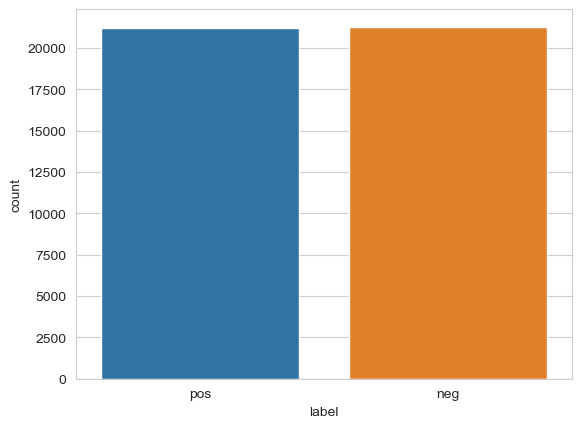

In [7]:
sns.set_style(style="whitegrid")
sns.countplot(data=train_supervised, x="label");

An example of raw and preprocessed reviews.

In [8]:
random.seed(42)
print("\n")
print("*"*75)
print("\n")
for i in range(3):
    idx = np.random.randint(len(test_supervised))
    print(train_supervised.iloc[idx]["review_text"])
    print("\n")
    print(train_supervised.iloc[idx]["cleaned_review_text"])
    print("\n")
    print("*"*75)
    print("\n")



***************************************************************************


Witchcraft/Witchery/La Casa 4/ and whatever else you wish to call it. How about..Crud.<br /><br />A gathering of people at a Massachusetts island resort are besieged by the black magic powers of an evil witch killing each individual using cruel, torturous methods. Photographer Gary(David Hasselhoff)is taking pictures for Linda(Catherine Hickland whose voice and demeanor resemble EE-YOR of the Winnie the Poo cartoon), a virgin studying witchcraft, on the island resort without permission. Rose Brooks(Annie Ross, portraying an incredibly rude bitch)is interested in perhaps purchasing the resort and, along with husband Freddie(Robert Champagne, who is always ogling other women much younger than him), pregnant daughter Jane(Linda Blair)and grandson Tommy(Michael Manchester, who just looks bored throughout, probably wanting to watch Sesame Street instead of starring in this rubbish), go by boat to the resort bein

Visualization of token lengths in reviews with labels as hue.

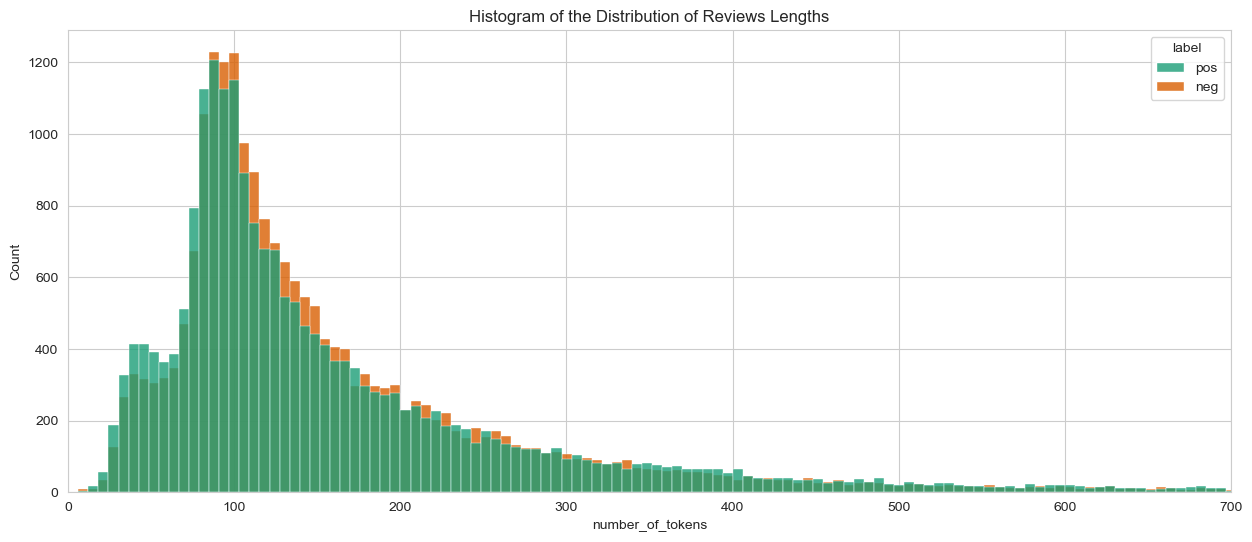

In [9]:
plt.figure(figsize=(15,6))
sns.histplot(data=train_supervised, x = "number_of_tokens", hue="label", palette="Dark2", alpha=0.8)
plt.xlim(0, 700)
plt.title("Histogram of the Distribution of Reviews Lengths");

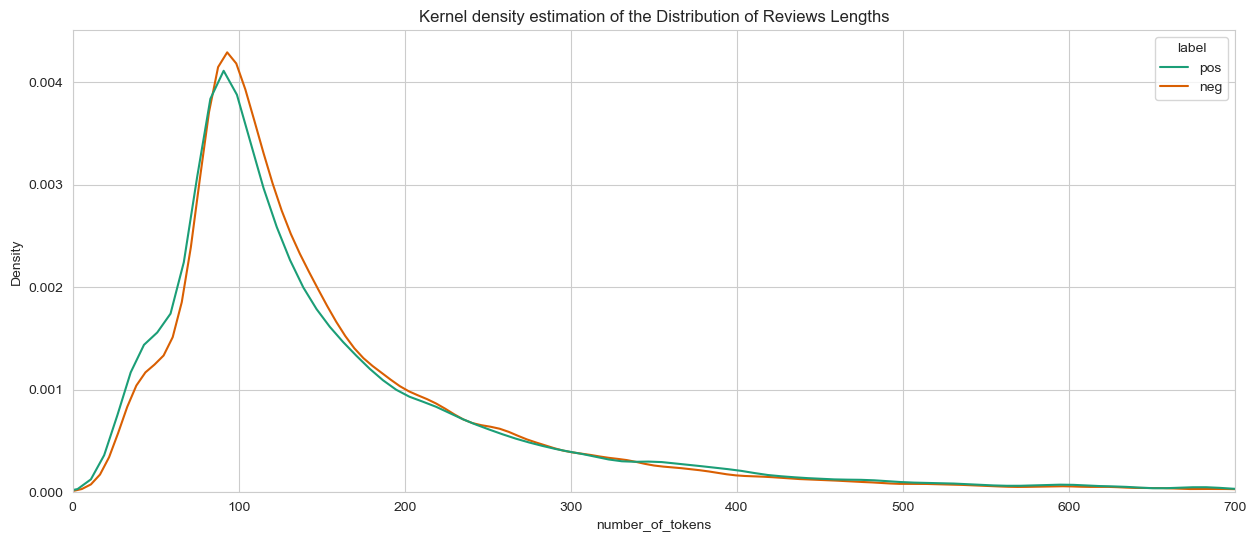

In [10]:
plt.figure(figsize=(15,6))
sns.kdeplot(data=train_supervised, x = "number_of_tokens", hue="label", palette="Dark2", bw_adjust=0.6)
plt.xlim(0, 700)
plt.title("Kernel density estimation of the Distribution of Reviews Lengths");

In [11]:
output_seq_len = int(np.percentile(train_supervised["number_of_tokens"].values, 99))
print(f"99% of reviews have length less then {output_seq_len} tokens.")

99% of reviews have length less then 616 tokens.


Because it's often the case that all valuable information about sentiment is contained in one of the last sentences, it's reasonable to preserve the maximum token length as the length of the sequence, even if it adds complexity to the model.

#
### Base model
#### TF-IDF + Naive Bayes
Here we create a base model that will demonstrate the minimum performance that an NLP classification neural network should aim to outperform.

In [12]:
X = supervised["cleaned_review_text"].values
y = pd.get_dummies(supervised["label"], drop_first=True, dtype=int).values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = Pipeline([
    ("tfidf",TfidfVectorizer(stop_words="english")),
    ("nb_clf",MultinomialNB())])

base_model.fit(X_train, y_train)

print(classification_report(y_test, base_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4945
           1       0.88      0.86      0.87      5055

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



As we can see, the TF-IDF + Naive Bayes base model achieves an accuracy of 87%. The F1 score of 87% demonstrates that the model is well balanced between classes.

### Creating a vocabulary and a tokenizer for review preprocessing into tensors. 
A vocabulary size larger than 5000 can lead to better model performance, but it starts to include specific actors' and producers' names, which is one form of hidden overfitting. So a vocabulary with 5000 is a relatively balanced choice.

In [13]:
%%time
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 700
vocab_for_data = Vocabulary(data=train_supervised["cleaned_review_text"], vocab_size=VOCAB_SIZE)
tokenizer = Tokenizer(vocab=vocab_for_data)

CPU times: total: 2min 26s
Wall time: 2min 31s


Saving vocabulary and tokenization classes for preparation on custom data and model deployment.

In [14]:
with open('vocab.pkl', 'wb') as file:
    pickle.dump(vocab_for_data, file)

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

Visualizing the work of a tokenizer.

In [15]:
idx = np.random.randint(0,len(supervised))

raw_text = supervised.iloc[idx]["review_text"]
print(raw_text)
print("\n")
test_text = supervised.iloc[idx]["cleaned_review_text"]
tokenized_text = tokenizer.tokenize(test_text, max_length=SEQUENCE_LENGTH)
print(test_text)
print("\n")
print(tokenized_text)
print("\n")
print(tokenizer.tokenize(tokenized_text, inverse=True))

It is more a subtle story of the fact that in Indian household how most decisions are taken by the man, how no attention is paid to the desires of the lady, for example how even when the husband and wife sleep together it would be a test for the husband whether he can control his desires, not to give the woman pleasure. And in such a type of scenario, women invariably have two choices, either to accept all this and take it into their own life, which is usually the case or not accept this and try to mould things to satisfy themselves, which makes a movie!<br /><br />Fire is a brilliantly directed story of the second option, which women choose for themselves, no sacrifice, not to serve anybody else, rather a decision for their own good. Somehow the whole idea of justifying lesbianism didn't find an acceptance in the Indian audience but if one looks the whole movie from an angle of self-expression, then the whole debate doesn't even arise.


be subtle story fact indian household decision 

### Creating DataLoader with custom dataset

In [15]:
class CustomDataset(Dataset):
    """
    Create dataset for dataloader from Pandas
    """
    def __init__(self, data, review, label=None, tokenize=tokenizer.tokenize, max_length=SEQUENCE_LENGTH, inverse=False):
        """
        Constructor method for initializing the dataset.

        Args:
            data (DataFrame): Pandas DataFrame containing text and labels.
            review (str): Column name for the text.
            label (str): Column name for the label (if available).
            tokenize (function): Tokenization function for processing text.
            max_length (int): Maximum sequence length.
            inverse (bool): Flag for inverse tokenization.
        """
        self.data = data
        self.review = review
        self.label = label
        self.tokenize = tokenize
        self.max_length = max_length
        self.inverse = inverse

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Retrieves a single sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the tokenized sequence and label (if available).
        """
        text = self.data.loc[index, self.review]
        
        tokens = self.tokenize(text, max_length=self.max_length, inverse=self.inverse)
        
        if self.label is not None:
            label = self.data.loc[index, self.label]

            if label == "pos":
                label = 1
            else:
                label = 0

            return tokens, label
        else:
            return tokens

In [16]:
BATCH_SIZE = 64
    
train_dataset = CustomDataset(data=train_supervised, review="cleaned_review_text", label="label")
test_dataset = CustomDataset(test_supervised, review="cleaned_review_text", label="label")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x28f4231cd00>,
 <torch.utils.data.dataloader.DataLoader at 0x28f4231ef50>)

visualisation of one dataset sample that will be feed into model.

In [17]:
sample_index = 0

tokens, label = train_dataset[sample_index]
print("Tokens:", tokens)
print("Label:", label)

Tokens: tensor([ 634,    6,    3,  138,  603,    3,   21,    1,  867,   21,  742,  836,
         224,    1, 4036,   33,    2,    5,   36,  184,   21,  952,  328,    3,
           4,  137,  353,    2,  678,    4,  620,    3,   59,    4, 2510, 1536,
           2,  150,   52, 1755,  118,    1,  137, 2489,  403,  298,   50,    2,
         182,    1,    1,   24,   69,  667,   50,   10,   11,  209,   98,  109,
           3,    1,    3,    4,    1,    2,  138,    3,    1,    2, 2847,  186,
          27, 2249,   40,   15,  205,   59,   40, 1865,    1,  138,   48, 1503,
         205,   26, 1233,  785,    1,  770,    2, 2847,   34,   14, 2980,    3,
          39, 1264,  182,    4, 1629,  567, 1060,    2, 1841,    3,    1,    6,
         411,  125,  157,    3,  416,   84,    3,   16,   74,  214,  274,  363,
           1,  386,    1,   12,   33,   19,   74,    1,    7,    2,    5,  940,
          76,    2,  770,   29,  111,   19,    6,    2,  835,  216,    2,    0,
           0,    0,    0,    0, 

### "Creating an NLP classification model. 
This model uses tokenized and padded reviews as input to the embedding layer. It then feeds the embedded tensors into an LSTM layer with dropout. Finally, for the final prediction, the model pool LSTM tensor with maximum values along the time dimension and uses fully connected layers with ReLU activation functions.

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            bidirectional=False, 
            dropout=dropout, 
            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):

        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x, _ = torch.max(x, dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Training model

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

vocab_size = VOCAB_SIZE + 2
embedding_dim = 128
hidden_dim = 32
output_dim = 2
num_layers = 1
dropout = 0.1

model_lstm = LSTMClassifier(
    vocab_size, 
    embedding_dim, 
    hidden_dim, 
    output_dim, 
    num_layers, 
    dropout).to(device)

checkpoint_lstm = ModelCheckpoint(
    save_path='models/', 
    model_name='best_lstm_model.pth', 
    save_best_only=True, 
    verbose=1)

early_stopping_lstm = EarlyStopping(patience=3)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_lstm.parameters(),
    lr=0.00075)

results_lstm = train(
    model=model_lstm, 
    train_dataloader=train_dataloader, 
    test_dataloader=test_dataloader, 
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
    model_checkpoint=checkpoint_lstm,
    early_stopping=early_stopping_lstm)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4917 | train_acc: 0.7559 | test_loss: 0.3403 | test_acc: 0.8531
Saved model with validation loss: 0.3403.
Epoch: 2 | train_loss: 0.2818 | train_acc: 0.8817 | test_loss: 0.2863 | test_acc: 0.8811
Saved model with validation loss: 0.2863.
Epoch: 3 | train_loss: 0.2267 | train_acc: 0.9108 | test_loss: 0.2776 | test_acc: 0.8835
Saved model with validation loss: 0.2776.
Epoch: 4 | train_loss: 0.1872 | train_acc: 0.9273 | test_loss: 0.2776 | test_acc: 0.8865
Saved model with validation loss: 0.2776.
Epoch: 5 | train_loss: 0.1588 | train_acc: 0.9407 | test_loss: 0.2823 | test_acc: 0.8910
Model's validation loss: 0.2776 didn't improve.
Epoch: 6 | train_loss: 0.1292 | train_acc: 0.9531 | test_loss: 0.2923 | test_acc: 0.8898
Model's validation loss: 0.2776 didn't improve.
Epoch: 7 | train_loss: 0.1047 | train_acc: 0.9636 | test_loss: 0.3080 | test_acc: 0.8881
Model's validation loss: 0.2776 didn't improve.
Early stopping triggered


As we can see, the model below is prone to overfitting. Reducing the complexity of the model leads to worse accuracy. Reducing the learning rate also causes underfitting. For that reason, I will preserve these hyperparameters and the learning rate.

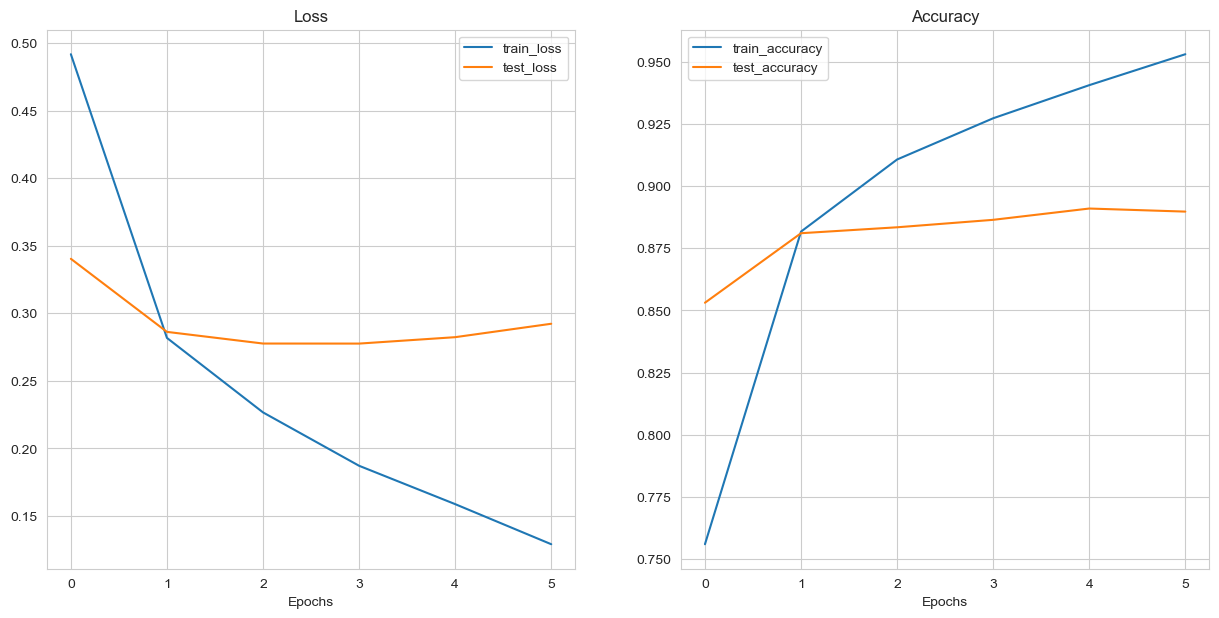

In [20]:
plot_loss_curves(results_lstm)

### Self learning
Loading unsupervised dataset.

In [21]:
unsupervised_dataset = CustomDataset(unsupervised, review="cleaned_review_text")
unsupervised_dataloader = DataLoader(unsupervised_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
unsupervised_dataloader

Importing the best-performing model.

In [22]:
MODEL_SAVE_PATH = r"models/best_lstm_model.pth"

loaded_best_model = LSTMClassifier(
    vocab_size, 
    embedding_dim, 
    hidden_dim, 
    output_dim, 
    num_layers, 
    dropout).to(device)

loaded_best_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Creating labels for unlabeled data by passing reviews into the trained model and return only certain predictions.

In [23]:
THRESHOLD = 0.9

test_probs = []

loaded_best_model.eval()
with torch.inference_mode():
    for X in unsupervised_dataloader:
        X = X.to(device)
        test_pred_logits = loaded_best_model(X)
        test_prob = torch.softmax(test_pred_logits, dim=1)
        
        test_probs.extend(test_prob[:, 1])
        
test_probs_np = [tensor.to("cpu").numpy().item() for tensor in test_probs]

pred_labels = []
for i in test_probs_np:
    if i >= THRESHOLD:
        pred_labels.append("pos")
    elif i <= 1-THRESHOLD:
        pred_labels.append("neg")
    else:
        pred_labels.append("uncertain")

In [24]:
unsupervised[f"predicted_label (Prob:{THRESHOLD})"] = pred_labels
unsupervised.head()

,review_text,cleaned_review_text,number_of_tokens,predicted_label (Prob:0.9)
0,"I admit, the great majority of films released ...","admit , great majority film release say 1933 n...",109,pos
1,"Take a low budget, inexperienced actors doubli...","take low budget , inexperienced actor double p...",113,neg
2,"Everybody has seen 'Back To The Future,' right...","everybody have see 'back future , ' right ? wh...",238,neg
3,Doris Day was an icon of beauty in singing and...,doris day be icon beauty sing act warm voice g...,72,pos
4,"After a series of silly, fun-loving movies, 19...","series silly , funloving movie , 1955 be big y...",144,pos


In [25]:
self_training = unsupervised[unsupervised[f"predicted_label (Prob:{THRESHOLD})"] != "uncertain"]
self_training = self_training[["cleaned_review_text", f"predicted_label (Prob:{THRESHOLD})"]]
self_training.columns = ["cleaned_review_text", "label"]

In [26]:
self_training.head(3)

,cleaned_review_text,label
0,"admit , great majority film release say 1933 n...",pos
1,"take low budget , inexperienced actor double p...",neg
2,"everybody have see 'back future , ' right ? wh...",neg


In [27]:
print(f"The length of dataframe with certain predictions: {len(self_training)} instances")

The length of dataframe with certain predictions: 34882 instances


In [28]:
train_supervised_prep = train_supervised[["cleaned_review_text", "label"]]
train_supervised_prep.columns = ["cleaned_review_text", "label"]

### Creating new train dataframe with additional samples

In [29]:
self_training_prepared = pd.concat([train_supervised_prep, self_training], axis=0, ignore_index=True)

In [30]:
self_training_prepared.head(3)

,cleaned_review_text,label
0,"enjoyable movie , without doubt , very evocati...",pos
1,"norma shearer dazzle be transform frump , addl...",pos
2,remake classic 1951 thing another world . 12 m...,pos


In [31]:
print(f"The length of the concatenated dataframe with manually labeled data and certain predicted labels: {len(self_training_prepared)} instances")

The length of the concatenated dataframe with manually labeled data and certain predicted labels: 77382 instances


These unsupervised reviews contain all possible ratings. In supervised labeled train/test sets, a negative review has a score of 4 or less out of 10, while a positive review has a score of 7 or more out of 10. Therefore, reviews with more neutral ratings are not included in the supervised train/test sets. This can lead to a shift in class balance, as we can see below. However, it does not necessarily mean that the model predicted classes poorly.

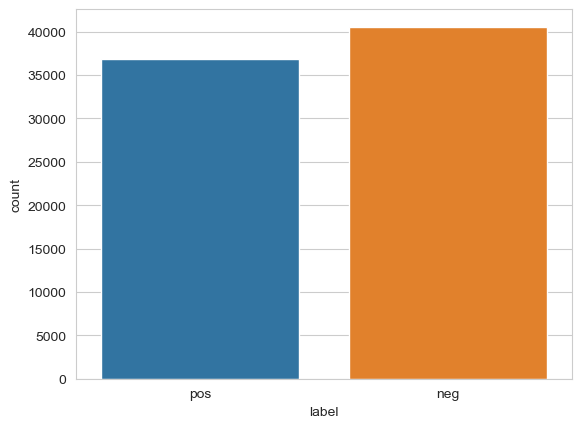

In [32]:
sns.countplot(data=self_training_prepared, x="label");

In [33]:
self_training_prepared["number_of_tokens"] = self_training_prepared["cleaned_review_text"].apply(lambda x: len(x.split()))

In [34]:
self_training_prepared.head()

,cleaned_review_text,label,number_of_tokens
0,"enjoyable movie , without doubt , very evocati...",pos,143
1,"norma shearer dazzle be transform frump , addl...",pos,92
2,remake classic 1951 thing another world . 12 m...,pos,266
3,"movie be almost unknown , be very good . lonel...",pos,299
4,"do start ? plot movie , be love two high schoo...",neg,259


Comparing the unsupervised data with the supervised data to check for consistency.

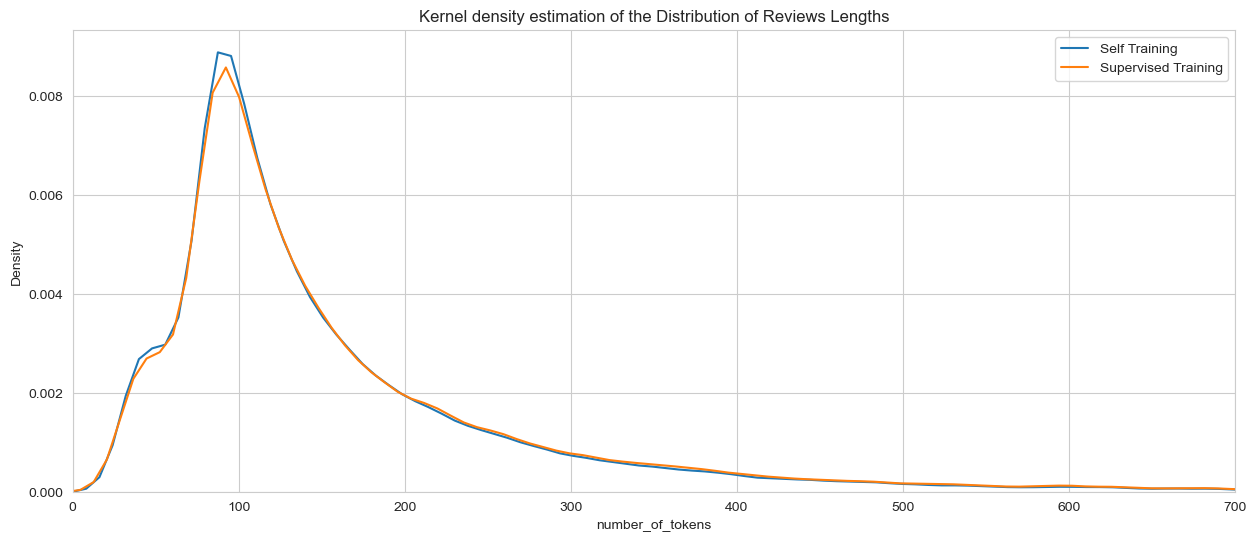

In [35]:
plt.figure(figsize=(15,6))

sns.kdeplot(data=self_training_prepared, x="number_of_tokens", palette="Dark2", bw_adjust=0.6, label="Self Training")
sns.kdeplot(data=train_supervised, x="number_of_tokens", palette="Dark2", bw_adjust=0.6, label="Supervised Training")

plt.xlim(0, 700)
plt.title("Kernel density estimation of the Distribution of Reviews Lengths")
plt.legend()

### Creating self-training DataLoader

In [36]:
self_train_dataset = CustomDataset(data=self_training_prepared, review="cleaned_review_text", label="label")
test_dataset = CustomDataset(test_supervised, review="cleaned_review_text", label="label")

self_train_dataloader = DataLoader(self_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

self_train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x28f41febfd0>,
 <torch.utils.data.dataloader.DataLoader at 0x28f41fe8970>)

### Training model with self-training technique

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

vocab_size = VOCAB_SIZE + 2
embedding_dim = 128
hidden_dim = 32
output_dim = 2
num_layers = 1
dropout = 0.2

model_lstm_self = LSTMClassifier(
    vocab_size, 
    embedding_dim, 
    hidden_dim, 
    output_dim, 
    num_layers, 
    dropout).to(device)

checkpoint_lstm_self = ModelCheckpoint(
    save_path='models/', 
    model_name='best_lstm_self_model.pth', 
    save_best_only=True, 
    verbose=1)

early_stopping_lstm_self = EarlyStopping(patience=3)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_lstm_self.parameters(),
    lr=0.0008)

results_lstm_self = train(
    model=model_lstm_self, 
    train_dataloader=self_train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device,
    model_checkpoint=checkpoint_lstm_self,
    early_stopping=early_stopping_lstm_self)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3137 | train_acc: 0.8597 | test_loss: 0.2929 | test_acc: 0.8725
Saved model with validation loss: 0.2929.
Epoch: 2 | train_loss: 0.1599 | train_acc: 0.9400 | test_loss: 0.2670 | test_acc: 0.8918
Saved model with validation loss: 0.2670.
Epoch: 3 | train_loss: 0.1287 | train_acc: 0.9533 | test_loss: 0.2609 | test_acc: 0.8961
Saved model with validation loss: 0.2609.
Epoch: 4 | train_loss: 0.1073 | train_acc: 0.9619 | test_loss: 0.2640 | test_acc: 0.8925
Model's validation loss: 0.2609 didn't improve.
Epoch: 5 | train_loss: 0.0904 | train_acc: 0.9685 | test_loss: 0.2769 | test_acc: 0.8922
Model's validation loss: 0.2609 didn't improve.
Epoch: 6 | train_loss: 0.0768 | train_acc: 0.9740 | test_loss: 0.2724 | test_acc: 0.8964
Model's validation loss: 0.2609 didn't improve.
Early stopping triggered


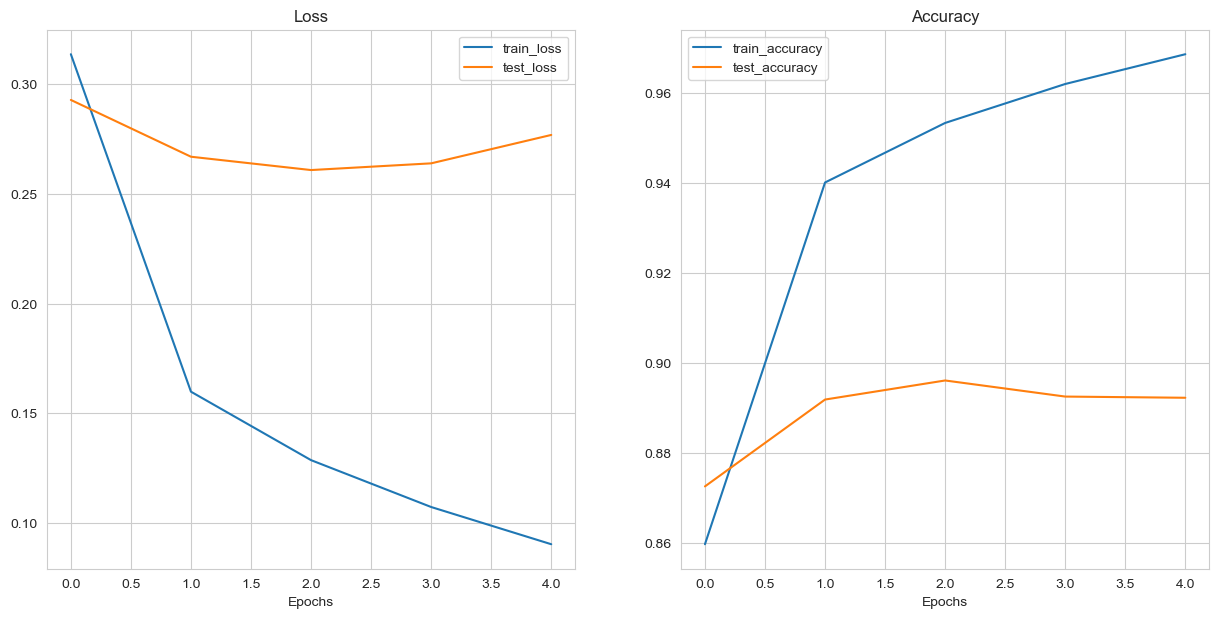

In [38]:
plot_loss_curves(results_lstm_self)

As we can see, the model achieves an accuracy of 89.6% compared to the 87% achieved by the base model.
##### 
    -The improvement in accuracy of the model compared to the base model: 2.6 %
    -The percentage improvement in accuracy of the model compared to the base model: 10.7 %